# Base3 lesson (silicon)

<div class="jumbotron">
  <h1 class="display-3">Third (basic) lesson with Abinit and AbiPy</h1>
  <p class="lead">Crystalline silicon.</p> 
  <hr class="my-4">
  <p>This lesson aims at showing you how to get the following physical properties, for an insulator:</p>
  <ul>
    <li>the total energy</li>
    <li>the lattice parameter</li>
    <li>the Kohn-Sham band structure</li>
  </ul>
  <p>
  You will learn about the use of k-points, as well as the smearing of the plane-wave kinetic energy cut-off.
  </p>
</div>

This tutorial is a complement to the standard [ABINIT tutorial on silicon](https://docs.abinit.org/tutorial/base3). 
Here, powerful flow and visualisation procedures
will be demonstrated. Still, some basic understanding of the stand-alone working of ABINIT is a prerequisite.
Also, in order to fully benefit from this Abipy tutorial, other more basic Abipy tutorials should have been followed,
as suggested in the [abitutorials index page](../index.ipynb).
  
## Table of Contents

- [Computing the total energy of silicon at fixed number of k-points](#Computing-the-total-energy-of-silicon-at-fixed-number-of-k-points)
- [Analysis of the results](#Analysis-of-the-results)
- [Determination of the lattice parameters](#Determination-of-the-lattice-parameters)
- [Computing the band-structure](#Computing-the-band-structure)

In [1]:
# Use this at the beginning of your script so that your code will be compatible with python3
from __future__ import print_function, division, unicode_literals

import numpy as np

import warnings 
warnings.filterwarnings("ignore")  # Ignore warnings

from abipy import abilab
abilab.enable_notebook() # This line tells AbiPy we are running inside a notebook

# This line configures matplotlib to show figures embedded in the notebook.
# Replace `inline` with `notebook` in classic notebook
%matplotlib inline

# Option available in jupyterlab. See https://github.com/matplotlib/jupyter-matplotlib
#%matplotlib widget  

## Computing the total energy of silicon at fixed number of k-points

Our goal is to study the convergence of the total energy of silicon versus the number of k-points. 
So we start by defining a function that generates a `Flow` of SCF calculations 
by looping over a predefined list of `ngkpt` values.
The crystalline structure is initialized from a CIF file while  other parameters 
such as the cutoff energy are fixed:

In [2]:
from lesson_base3 import build_ngkpt_flow
abilab.print_source(build_ngkpt_flow)

Let's call the function to build the flow:

In [3]:
flow = build_ngkpt_flow(options=None)

In total, we have four `ScfTasks` that will be executed in the `flow_base3_ngkpt` directory:

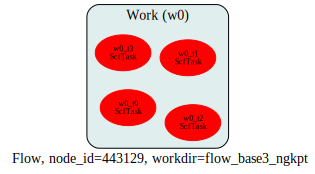

In [4]:
flow.get_graphviz()

This is the input of the first task `w0_t0`:

In [5]:
flow[0][0].input

<AbinitInput at 140184300798528>

and these are the divisions of the k-mesh for the four different calculations:

In [6]:
for task in flow.iflat_tasks():
    print(task.pos_str, "uses ngkpt:", task.input["ngkpt"])

w0_t0 uses ngkpt: (2, 2, 2)
w0_t1 uses ngkpt: (4, 4, 4)
w0_t2 uses ngkpt: (6, 6, 6)
w0_t3 uses ngkpt: (8, 8, 8)


but we can achieve the same goal with:

In [7]:
flow.get_vars_dataframe("ngkpt", "ecut")

,ngkpt,ecut,class
w0_t0,"(2, 2, 2)",8,ScfTask
w0_t1,"(4, 4, 4)",8,ScfTask
w0_t2,"(6, 6, 6)",8,ScfTask
w0_t3,"(8, 8, 8)",8,ScfTask


At this point, we could run the flow in the notebook by just calling:

    flow.make_scheduler().start()

or, alternatively, execute the `lesson_base3.py` script to build 
the directory with the flow and then use:

    abirun.py flow_base3_ngkpt scheduler

inside the terminal.

## Analysis of the results

We could use the API provided by the flow to extract the total energies from
the GSR files. Something like:

```python
nkpt_list, ene_list = [], []
for task in flow.iflat_tasks():
    with task.open_gsr() as gsr:
        nkpt_list.append(gsr.nkpt)
        ene_list.append(gsr.energy)
        
# Assuming values are already sorted wrt nkpt
import matplotlib.pyplot as plt
plt.plot(nkpt_list, ene_list, marker="o");
```

but it is much easier to create a `GsrRobot` that will do the work for us:

In [8]:
robot_enekpt = abilab.GsrRobot.from_dir("flow_base3_ngkpt")
robot_enekpt

Label                     Relpath
------------------------  -----------------------------------------
w0/t2/outdata/out_GSR.nc  flow_base3_ngkpt/w0/t2/outdata/out_GSR.nc
w0/t3/outdata/out_GSR.nc  flow_base3_ngkpt/w0/t3/outdata/out_GSR.nc
w0/t1/outdata/out_GSR.nc  flow_base3_ngkpt/w0/t1/outdata/out_GSR.nc
w0/t0/outdata/out_GSR.nc  flow_base3_ngkpt/w0/t0/outdata/out_GSR.nc

In the next lines, we are going to generate a pandas `Dataframe` with
the most important results so that we can show how to use the pandas API to analyze the data:

In [9]:
ene_table = robot_enekpt.get_dataframe()
ene_table.keys()

Index(['formula', 'natom', 'alpha', 'beta', 'gamma', 'a', 'b', 'c', 'volume',
       'abispg_num', 'spglib_symb', 'spglib_num', 'spglib_lattice_type',
       'energy', 'pressure', 'max_force', 'ecut', 'pawecutdg', 'tsmear',
       'nkpt', 'nsppol', 'nspinor', 'nspden'],
      dtype='object')

The dataframe contains several columns but
we are mainly interested in the number of k-points `nkpt` and in the `energy` (given in eV).
Let's massage a bit the data to facilitate the post-processing:

In [10]:
# We are gonna plot f(nkpt) so let's sort the rows first.
ene_table.sort_values(by="nkpt", inplace=True) 

# Add a column with energies in Ha and another column with the difference wrt to the last point.
ene_table["energy_Ha"] = ene_table["energy"] * abilab.units.eV_to_Ha
ene_table["ediff_Ha"] = ene_table["energy_Ha"] - ene_table["energy_Ha"][-1]

before printing a subset of the columns with the syntax:

In [11]:
ene_table[["nkpt", "energy", "energy_Ha", "ediff_Ha"]]

,nkpt,energy,energy_Ha,ediff_Ha
w0/t0/outdata/out_GSR.nc,2,-241.251548,-8.865831,0.006242
w0/t1/outdata/out_GSR.nc,10,-241.417961,-8.871946,0.000126
w0/t2/outdata/out_GSR.nc,28,-241.421160,-8.872064,0.000009
w0/t3/outdata/out_GSR.nc,60,-241.421393,-8.872073,0.000000


If you do not like tables and prefer figures, use:

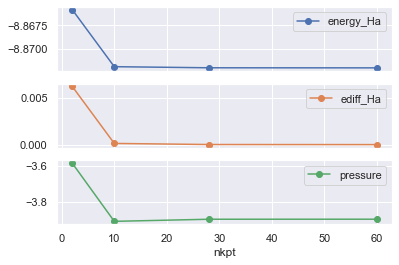

In [12]:
ene_table.plot(x="nkpt", y=["energy_Ha", "ediff_Ha", "pressure"], style="-o", subplots=True);

The difference between dataset 3 and dataset 4 is rather small. Even the dataset 2 gives an accuracy of about 0.0001 Ha.
So, our converged value for the total energy (at fixed `acell` and `ecut`) is -8.8726 Ha.

Now that we have learned a bit how to use pandas `Dataframes`, we can finally reveal
that the AbiPy robots *already* provide methods to perform this kind of convergence studies 
so that we do not need to manipulate pandas dataframes explicitly.
For example, we can perform the same analysis with a single line:

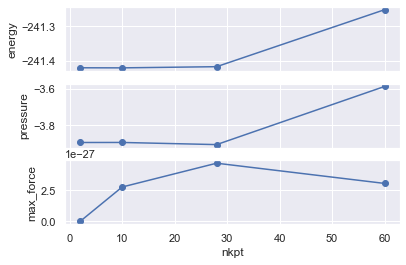

In [13]:
robot_enekpt.plot_gsr_convergence(sortby="nkpt");

We can also pass a function that will be called by the robot to compute the values along the x-axis 
and sort the results.
The docstring of the function is used as label of the x-axis:

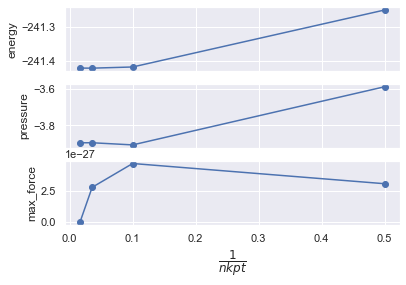

In [14]:
def inv_nkpt(abifile):
    r"""$\dfrac{1}{nkpt}$"""
    return 1 / abifile.nkpt
    
robot_enekpt.plot_gsr_convergence(sortby=inv_nkpt);    

In [15]:
#robot_enekpt.plot_lattice_convergence(sortby="nkpt");

## Determination of the lattice parameters

At this point, the original Abinit tutorial proceeds with a convergence study for the optimized
lattice parameters as function of the k-point sampling.
In AbiPy, we only need to build different relaxation tasks with a slightly different input
in which only `ngkpt` is changed.

In [16]:
from lesson_base3 import build_relax_flow
abilab.print_source(build_relax_flow)

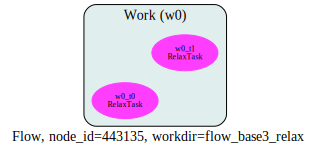

In [17]:
relax_flow = build_relax_flow(options=None)
relax_flow.get_graphviz()

<div class="alert alert-info">
If you want to run the flow from the shell, open lesson_base3.py and change the main function
so that it calls build_relax_flow instead of build_ngkpt_flow.
</div>

This is our first structural relaxation with AbiPy and this gives us the opportunity to introduce the `HIST.nc` file.
This file stores the history of the relaxation 
(energies, forces, stresses, lattice parameters and atomic positions at the different relaxation steps).

As usual, we use `abiopen` to generate an AbiPy object:

In [18]:
hist = abilab.abiopen("flow_base3_relax/w0/t1/outdata/out_HIST.nc")
print(hist)

================================= File Info =================================
Name: out_HIST.nc
Directory: /Users/gmatteo/git_repos/abipy_book/abipy_book/base3/flow_base3_relax/w0/t1/outdata
Size: 4.24 kb
Access Time: Thu Jul  8 02:48:30 2021
Modification Time: Thu Jul  8 01:23:26 2021
Change Time: Thu Jul  8 01:23:26 2021

============================= Initial Structure =============================
Full Formula (Si2)
Reduced Formula: Si
abc   :   3.866975   3.866975   3.866975
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c  cartesian_forces
---  ----  ----  ----  ----  -----------------------------------------------------------
  0  Si    0     0     0     [ 4.10231609e-27 -5.80155106e-27 -3.31586262e-27] eV ang^-1
  1  Si    0.25  0.25  0.25  [-4.10231609e-27  5.80155106e-27  3.31586262e-27] eV ang^-1

Number of relaxation steps performed: 4
============================== Final structure ==============================
Full Formula (Si2)
Reduced Formul

To plot the evolution of the most important physical quantities, use:

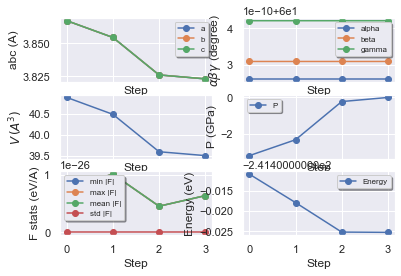

In [19]:
hist.plot();

In [20]:
hist_robot = abilab.HistRobot.from_dir("flow_base3_relax")
    
hist_table = hist_robot.get_dataframe()

There are several entries in the `DataFrame`:

In [21]:
hist_table.keys()

Index(['formula', 'natom', 'alpha', 'beta', 'gamma', 'a', 'b', 'c', 'volume',
       'abispg_num', 'spglib_symb', 'spglib_num', 'spglib_lattice_type',
       'num_steps', 'final_energy', 'final_pressure', 'final_fmin',
       'final_fmax', 'final_fmean', 'final_fstd', 'final_drift',
       'initial_fmin', 'initial_fmax', 'initial_fmean', 'initial_fstd',
       'initial_drift'],
      dtype='object')

Let's select some of them with:

In [22]:
hist_table[["alpha", "a", "final_energy", "final_pressure", "num_steps"]]

,alpha,a,final_energy,final_pressure,num_steps
w0/t1/outdata/out_HIST.nc,60.0,3.822962,-241.425217,-0.008757,4
w0/t0/outdata/out_HIST.nc,60.0,3.829282,-241.255630,-0.013259,4


and print the evolution of important physical properties extracted from the two files:

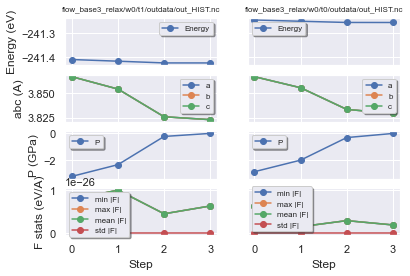

In [23]:
hist_robot.gridplot(what_list=["energy", "abc", "pressure", "forces"]);

We can also compare the two structural relaxations with:

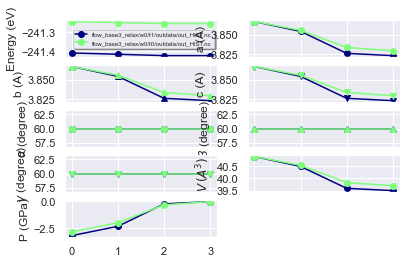

In [24]:
hist_robot.combiplot();

Unfortunately the `HIST.nc` file does not have enough metadata. 
In particular we would like to have information about the k-point sampling 
so that we can analyze the convergence of the optimized lattice parameters wrt `nkpt`.
Fortunately the `GSR.nc` has all the information we need and it is just a matter
of replacing the `HistRobot` with a `GsrRobot`:

In [25]:
with abilab.GsrRobot.from_dir("flow_base3_relax") as relkpt_robot:
    relax_table = relkpt_robot.get_dataframe().sort_values(by="nkpt")
    dfs = relkpt_robot.get_structure_dataframes()

In [26]:
relax_table[["energy", "a", "pressure", "max_force", "pressure"]]

,energy,a,pressure,max_force,pressure
w0/t0/outdata/out_GSR.nc,-241.255630,3.829282,-0.013259,1.913429e-27,-0.013259
w0/t1/outdata/out_GSR.nc,-241.425217,3.822962,-0.008757,6.356619e-27,-0.008757


Plotting the energy, the lattice parameter `a` in Bohr and the pressure in `GPa` vs `nkpt` is really a piece of cake!

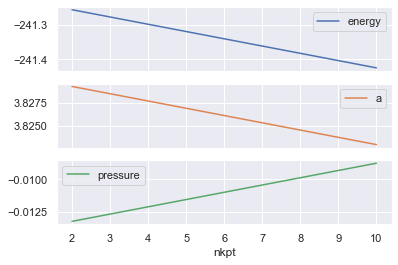

In [27]:
relax_table.plot(x="nkpt", y=["energy", "a", "pressure"], subplots=True);

Alternatively, one can use the `GsrRobot` API:

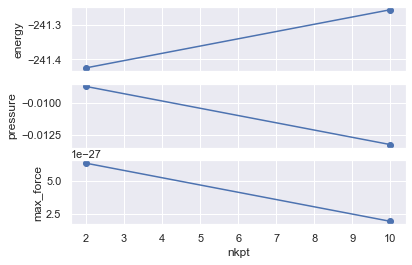

In [28]:
relkpt_robot.plot_gsr_convergence(sortby="nkpt");

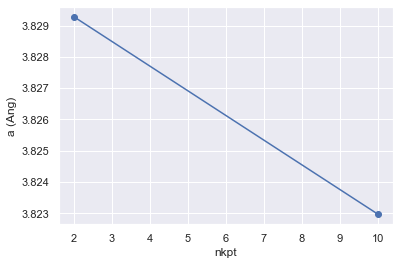

In [29]:
relkpt_robot.plot_lattice_convergence(what_list=["a"], sortby="nkpt");

We fix the parameters `acell` to the theoretical value of 3*10.216, 
and we fix also the grid of k points 
(the 4x4x4 FCC grid, equivalent to a 8x8x8 Monkhorst-pack grid).
We will ask for 8 bands (4 valence and 4 conduction).

## Computing the band structure

A band structure can be computed by solving the Kohn-Sham equation for many different k points, along different lines of the Brillouin zone.
The potential that enters the Kohn-Sham equation must be derived from a previous self-consistent calculation, 
and will not vary during the scan of different k-point lines.

This is our first Flow with dependencies in the sense that the band structure calculation must be 
connected to a previous SCF run. 
Fortunately AbiPy provides a factory function to generate this kind of workflow.
We only need to focus on the definition of the two inputs:

In [30]:
from lesson_base3 import build_ebands_flow
abilab.print_source(build_ebands_flow)

The `Flow` consists of a single `Work` with two `Tasks` 
(`ScfTask` with a k-mesh and a `NscfTask` performed on the k-path).

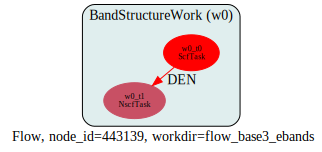

In [31]:
ebands_flow = build_ebands_flow(options=None)
ebands_flow.get_graphviz()

<div class="alert alert-info">
If you want to run the flow from the shell, open lesson_base3.py and change the main function
so that it calls build_ebands_flow.
</div>

Let's extract the band structure from the `GSR.nc` file produced by the `NscfTask`:

In [32]:
with abilab.abiopen("flow_base3_ebands/w0/t1/outdata/out_GSR.nc") as gsr:
    ebands_kpath = gsr.ebands

and plot it with:

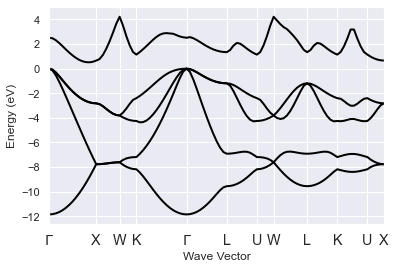

In [33]:
ebands_kpath.plot();

Visual inspection reveals that the width of the valence band is ~11.8 eV, 
the lowest unoccupied state at X is ~0.5 eV higher than the top of the valence band at $\Gamma$. 
Bulk silicon is described as an indirect band gap material (this is correct), with a band-gap 
of about 0.5 eV (this is quantitatively quite wrong: 
the experimental value is 1.17 eV at 25 degree Celsius, the famous **DFT band-gap problem**). 
The minimum of the conduction band is even slightly displaced with respect to X.

Unfortunately, it seems that AbiPy does not agree with us:

In [34]:
print(ebands_kpath)

================================= Structure =================================
Full Formula (Si2)
Reduced Formula: Si
abc   :   3.866975   3.866975   3.866975
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c  cartesian_forces
---  ----  ----  ----  ----  -----------------------------------------------------------
  0  Si    0     0     0     [5.14220675e+101 5.14220675e+101 5.14220675e+101] eV ang^-1
  1  Si    0.25  0.25  0.25  [5.14220675e+101 5.14220675e+101 5.14220675e+101] eV ang^-1

Abinit Spacegroup: spgid: 227, num_spatial_symmetries: 48, has_timerev: True, symmorphic: True

Number of electrons: 8.0, Fermi level: 5.567 (eV)
nsppol: 1, nkpt: 101, mband: 5, nspinor: 1, nspden: 1
smearing scheme: none (occopt 1), tsmear_eV: 0.272
Direct gap:
    Energy: 2.512 (eV)
    Initial state: spin: 0, kpt: [+0.000, +0.000, +0.000], name: $\Gamma$, weight: 0.000, band: 3, eig: 5.567, occ: 2.000
    Final state:   spin: 0, kpt: [+0.000, +0.000, +0.000], name: $\Ga

The reason is that ther Fermi energy in `ebands_kpath` is not completely consistent with the band structure. 
The Fermi energy, indeed, has been taken from the previous GS-SCF calculation performed 
on a shifted k-mesh, the $\Gamma$ point was not included and therefore the Fermi energy is underestimated.

To fix this problem we have to change manually the Fermi energy and set it to the maximum of the valence bands:

In [35]:
ebands_kpath.set_fermie_to_vbm()
print(ebands_kpath)

================================= Structure =================================
Full Formula (Si2)
Reduced Formula: Si
abc   :   3.866975   3.866975   3.866975
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c  cartesian_forces
---  ----  ----  ----  ----  -----------------------------------------------------------
  0  Si    0     0     0     [5.14220675e+101 5.14220675e+101 5.14220675e+101] eV ang^-1
  1  Si    0.25  0.25  0.25  [5.14220675e+101 5.14220675e+101 5.14220675e+101] eV ang^-1

Abinit Spacegroup: spgid: 227, num_spatial_symmetries: 48, has_timerev: True, symmorphic: True

Number of electrons: 8.0, Fermi level: 5.567 (eV)
nsppol: 1, nkpt: 101, mband: 5, nspinor: 1, nspden: 1
smearing scheme: none (occopt 1), tsmear_eV: 0.272
Direct gap:
    Energy: 2.512 (eV)
    Initial state: spin: 0, kpt: [+0.000, +0.000, +0.000], name: $\Gamma$, weight: 0.000, band: 3, eig: 5.567, occ: 2.000
    Final state:   spin: 0, kpt: [+0.000, +0.000, +0.000], name: $\Ga

Now the AbiPy results are consistent with our initial analysis:

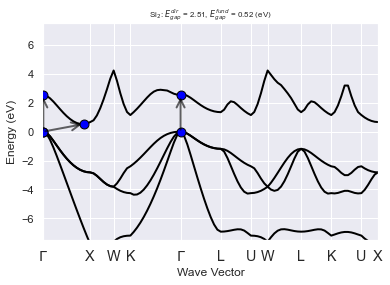

In [36]:
ebands_kpath.plot(with_gaps=True);

In [37]:
# We can also plot the k-path in the Brillouin zone with:
#ebands_kpath.kpoints.plot();

The `GSR` file produced by the first task contains energies on a homogeneous k-mesh.
We can therefore compute the DOS by invoking the `get_edos` method:

In [38]:
with abilab.abiopen("flow_base3_ebands/w0/t0/outdata/out_GSR.nc") as gsr:
    ebands_kmesh = gsr.ebands
    
edos = ebands_kmesh.get_edos()

and plot the DOS with:

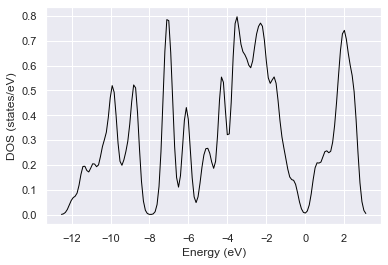

In [39]:
edos.plot();

where the zero of the energy axis is set to the Fermi level $\epsilon_F$ obtained by solving:
    
$$\int_{-\infty}^{\epsilon_F} g(\epsilon)\,d\epsilon = N$$

for $\epsilon_F$ with $N$ the number of electrons per unit cell.
Note that the DOS is highly sensitive to the sampling of the IBZ and to the value of the broadening,
especially in metallic systems.

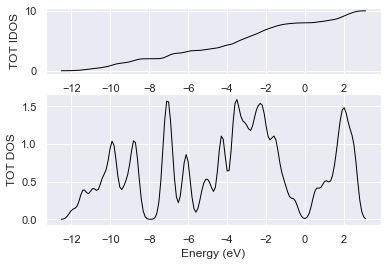

In [40]:
edos.plot_dos_idos();

Want to make  a nice picture of the band dispersion with a second panel for the DOS?

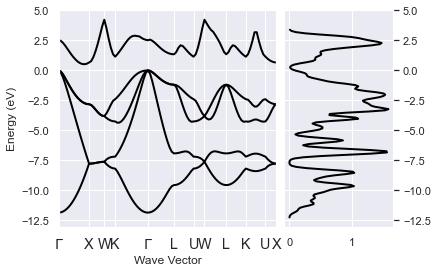

In [41]:
ebands_kpath.plot_with_edos(edos);

It is important to stress that each panel in the above figure is aligned with respect to its own Fermi energy
and these values are not necessarly equal:

In [42]:
print(ebands_kpath.fermie, edos.fermie)

5.567493594319245 eV 5.838293314475842


We can always plot the bands and the DOS without setting their Fermi energy to zero by using:

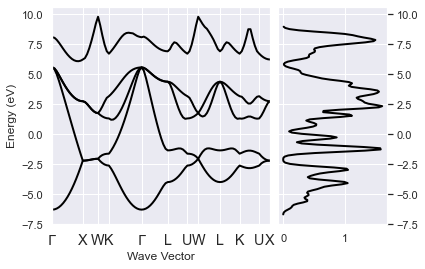

In [43]:
ebands_kpath.plot_with_edos(edos, e0=0);

This figure shows that the bands and the DOS are not perfectly aligned.
More specifically we would expect the DOS to be zero at the bottom/top of the conduction.
This problems is essentially due to the use of a relatively large gaussian broadening.
One should therefore compute the DOS with a much denser IBZ mesh and a much smaller broadening 
to solve this *alignment issue*